In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, rankdata

In [5]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, addCorrFeats=True):
        self.size = size
        #these two are counters that help create unique column names for generatable features later
        self.cons = 1
        self.cats = 1
        
        #create the target variable with the specified skewneww
        targetMean = 6000
        targetStd = 2000
        self.hoursSpent = skewnorm.rvs(a=targetskew,loc=targetMean,scale=targetStd, size=self.size)
        df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        sortedNormal = np.sort(skewnorm.rvs(a=0, loc=targetMean,scale=targetStd, size=self.size))
        self.normWithTargetSorting = [sortedNormal[i-1] for i in rankdata(self.hoursSpent, method='ordinal')]
        
        
        if addCorrFeats == True:
            #This adds a normally distributed feature that's typically around .65 correlation
            df['screenActions'] = [int(x+np.random.randint(low=(targetMean - targetStd*2),
                                    high=(targetMean + targetStd*2))) for x in self.normWithTargetSorting]
            
            #This adds a uniformly distributed feature that's typically around .13 correlation
            def unif(self, p):
                return np.random.choice(a=[np.random.uniform(high=150),np.random.uniform(low=150.1,high=300)], p=p)
            df ['picsPerMonth'] = [unif(self,[.4,.6]) if x > targetMean else 
                                   unif(self,[.6,.4]) for x in self.normWithTargetSorting]
            
            #This adds a poisson distribution that's typically around .17 correlation
            df['timesDropped'] = [np.random.poisson(lam=1.5) if x > targetMean else 
                                  np.random.poisson(lam=1.0) for x in self.normWithTargetSorting]
            
            #This adds a dual-peak gamma distribution for owner age, typically around -.12 correlation
            def gam(self, p):
                return np.random.choice(a=[np.random.gamma(shape=25.0,scale=1),
                              np.random.gamma(shape=25.0,scale=1.8)], p=p)
            df['ownerAge'] = [gam(self,[.6,.4]) if x >targetMean else 
                              gam(self,[.4,.6]) for x in self.normWithTargetSorting]
            
            #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
            df['rooted'] = [np.random.binomial(1, .05) if x > targetMean*1.5 else
                            np.random.binomial(1, .005) for x in self.normWithTargetSorting]
            
            #This adds a categorical variable that slightly corresponds to the target
            def osChoice(self, p):
                return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
            df ['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                                   osChoice(self,[.335,.635,.03]) for x in self.normWithTargetSorting]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [10]:
#this code checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['hoursSpent','screenActions'])
    picscorrs.append(cor.loc['hoursSpent','picsPerMonth'])
    dropscorrs.append(cor.loc['hoursSpent','timesDropped'])
    agecorrs.append(cor.loc['hoursSpent','ownerAge'])
    rootcorrs.append(cor.loc['hoursSpent','rooted'])
print('Correlations: \n')
print('screenActions\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsPerMonth\n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped\n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge\n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')


Correlations: 

screenActions
 0.6528913940051859 
 0.01826973517314242 

picsPerMonth
 0.1384548992111001 
 0.032022649957070555 

timesDropped
 0.17741721824640677 
 0.029730421397513074 

ownerAge
 -0.1320863476798016 
 0.03236880033545407 

rooted
 0.05891398676816536 
 0.04315439570349577 

done in  8.211623668670654 seconds


---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [80]:
viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted,os
0,5322.487375,14216,22.855327,1,32.273256,0,iOS
1,8963.722619,11164,137.360042,1,35.487678,0,Android
2,6836.536904,15506,134.281613,1,21.037701,0,iOS
3,4387.177770,12889,50.201005,2,29.253853,0,Android
4,9307.902037,18976,238.685257,0,19.406712,0,iOS


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.655117,0.138930,0.174611,-0.120545,0.063026
screenActions,0.655117,1.000000,0.080819,0.120989,-0.072237,0.032683
picsPerMonth,0.138930,0.080819,1.000000,0.039374,-0.031461,-0.003709
timesDropped,0.174611,0.120989,0.039374,1.000000,-0.033535,0.015712
ownerAge,-0.120545,-0.072237,-0.031461,-0.033535,1.000000,-0.000780
rooted,0.063026,0.032683,-0.003709,0.015712,-0.000780,1.000000


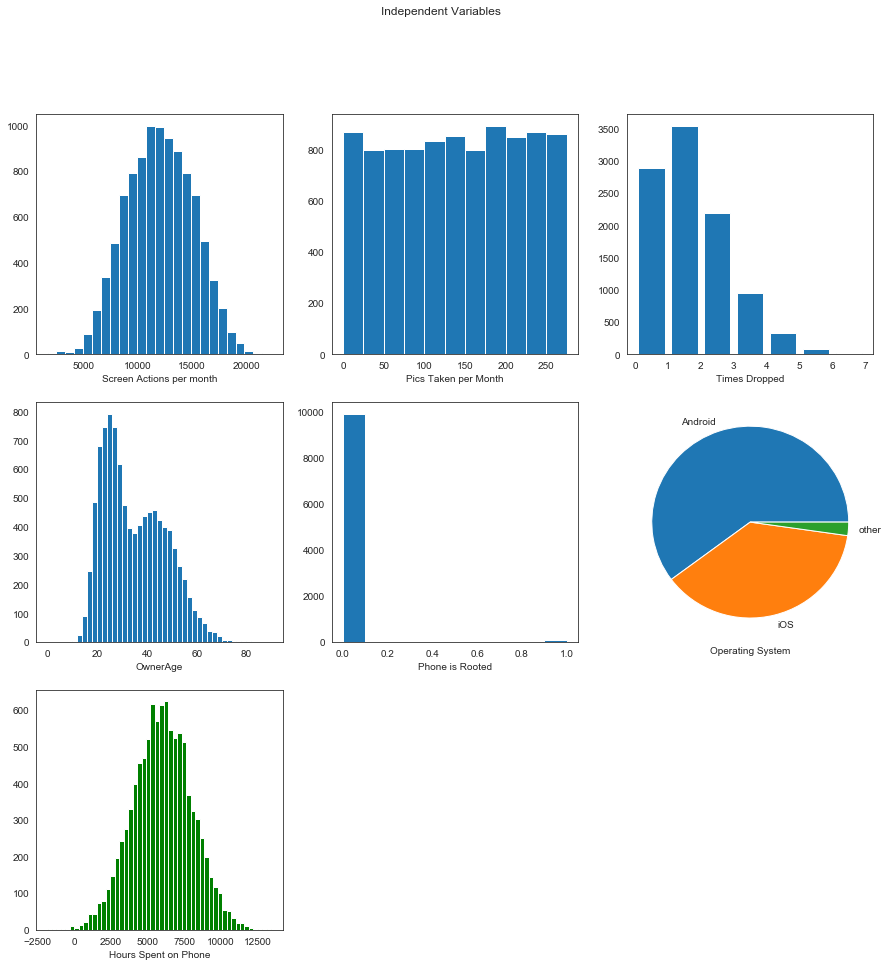

In [81]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsPerMonth, bins=np.arange(0,max(viz.df.picsPerMonth),25))
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),2))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
take.df['os'].value_counts().plot(kind='pie')
plt.xlabel('Operating System')
plt.ylabel('')
plt.subplot(337)
plt.hist(viz.df.hoursSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')

plt.show()







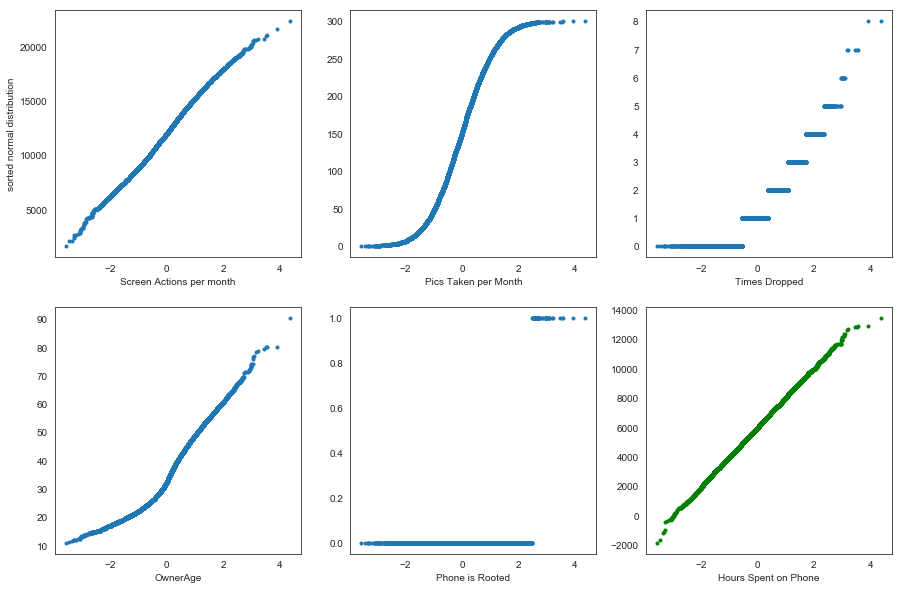

In [82]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsPerMonth'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['hoursSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.ylabel('sorted normal distribution')
plt.xlabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.xlabel('Pics Taken per Month')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.xlabel('Times Dropped')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.xlabel('OwnerAge')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.xlabel('Phone is Rooted')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.xlabel('Hours Spent on Phone')
plt.show()

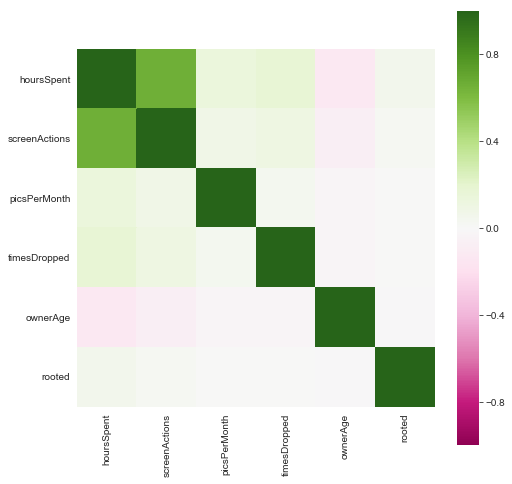

In [29]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

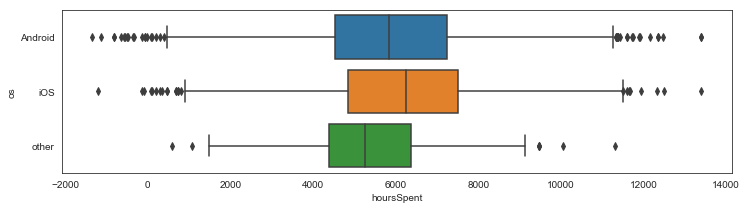

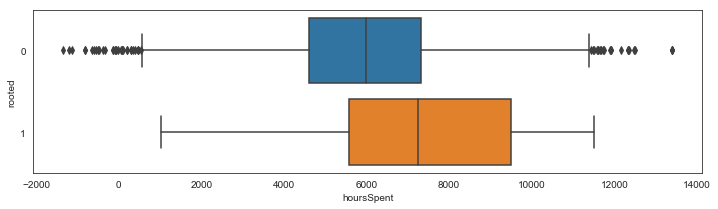

In [30]:
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [89]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [94]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression()

In [95]:
#sklearn
x = normal.df['screenActions']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.40158625 0.4432534  0.37188697 0.42557086 0.41453393 0.408564
 0.42675917 0.47639842 0.45212951 0.37471296]
Coefficients: 
 [0.42902349]
Intercept: 
 832.641166097439
----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     7282.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:19:58   Log-Likelihood:                -87527.
No. Observations:               10000   AIC:                         1.751e+05
Df Residuals:                    9998   BIC:                         1.751e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       832.6412     62.147     13.398      0.000     710.820     954.462
screenActions     0.4290      0.005     85.333      0.000       0.419       0.439
==============================================================================
Omnibus:                       17.232   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.487
Skew:                          -0.017   Prob(JB):                     0.000715
Kurtosis:                       2.817   Cond. No.                     5.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

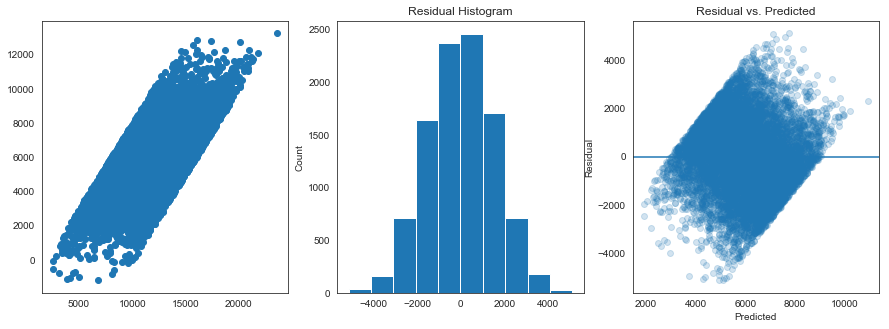

In [101]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y)
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# What if the target variable had a right skew instead of being normally distributed?

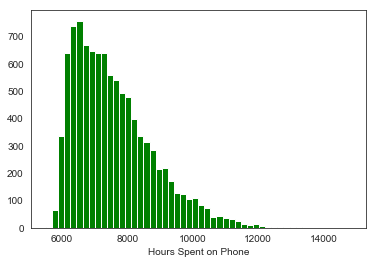

In [87]:
rightskew = createSet(targetskew=15, size=10000)
plt.hist(rightskew.df.hoursSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone')
plt.show()

regr = linear_model.LinearRegression()

In [88]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.41105358 0.40634595 0.38731831 0.37345254 0.42519292 0.39848832
 0.42974845 0.39381257 0.38924677 0.39922005]
Coefficients: 
 [0.25065989]
Intercept: 
 4581.674797745858
----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     6727.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:15:51   Log-Likelihood:                -82649.
No. Observations:               10000   AIC:                         1.653e+05
Df Residuals:                    9998   BIC:                         1.653e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4581.6748     37.764    121.324      0.000    4507.650    4655.700
screenActions     0.2507      0.003     82.017      0.000       0.245       0.257
==============================================================================
Omnibus:                      950.796   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1336.940
Skew:                           0.760   Prob(JB):                    4.87e-291
Kurtosis:                       3.947   Cond. No.                     4.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC